In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential,load_model
from keras.layers import *
from keras.optimizers import Adam
from keras.preprocessing import image
import keras.backend as K
import cv2

Using TensorFlow backend.


In [2]:
import os
import shutil
import pandas as pd

## Testing the trained model

In [3]:
model = load_model("model.hdf5")

val_path = "./covid19dataset/val/"
test_imgs = []

for img_ in os.listdir(val_path+"/Covid19"):
    img_path = os.path.join(val_path+"/Covid19",img_)
    img = image.load_img(img_path,target_size = (224,224))
    img = image.img_to_array(img)/255.0
    test_imgs.append(img)
    
for img_ in os.listdir(val_path+"/Normal"):
    img_path = os.path.join(val_path+"/Normal",img_)
    img = image.load_img(img_path,target_size = (224,224))
    img = image.img_to_array(img)/255.0
    test_imgs.append(img)

test_imgs = np.array(test_imgs)
print(test_imgs.shape)

(56, 224, 224, 3)


In [4]:
# labels of all the images
# Covid --> 0, Normal --> 1
lth = int(test_imgs.shape[0]/2)
labels = np.hstack((np.zeros(lth),np.ones(lth)))
print(labels.shape)
print(labels)

(56,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


In [5]:
y_pred = []
for i in range(test_imgs.shape[0]):
    img = np.expand_dims(test_imgs[i],axis=0)
    pred = model.predict_classes(img)
    y_pred.append(pred[0][0])

y_pred = np.array(y_pred)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [6]:
np.sum(y_pred == labels)/y_pred.shape[0]

0.9821428571428571

## Grad-CAM
- A Class Activation Mapping used to interpret the features learned by the model

In [7]:
[i.name for i in model.layers]

['conv2d_5',
 'conv2d_6',
 'max_pooling2d_4',
 'dropout_5',
 'conv2d_7',
 'max_pooling2d_5',
 'dropout_6',
 'conv2d_8',
 'max_pooling2d_6',
 'dropout_7',
 'flatten_2',
 'dense_3',
 'dropout_8',
 'dense_4']

[[1]]


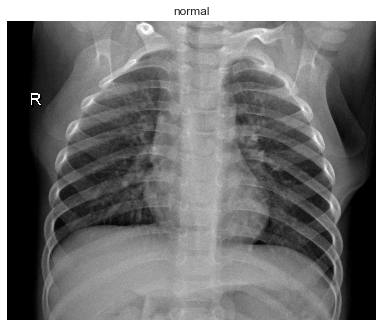

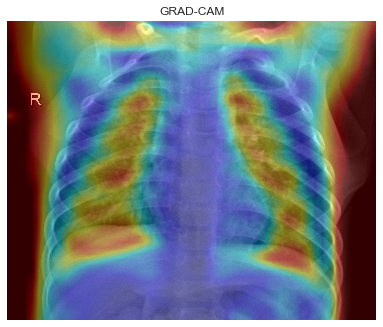

In [8]:
img = test_imgs[40]
img = np.expand_dims(img,axis = 0)

preds = model.predict(img)
print(pred)
class_idx = np.argmax(preds[0][0])
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("conv2d_8")

grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img])
for i in range(128):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.style.use("seaborn")
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
plt.imshow(img)
plt.axis('off')
plt.title("normal")
plt.show()
plt.imshow(superimposed_img)
plt.axis('off')
plt.title("GRAD-CAM")
plt.show()